### DETECCIÓN DE OUTLIERS POR AUTOENCODER

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from datetime import datetime
import seaborn as sns

from funciones_OD import *

from sklearn.metrics import mean_squared_error
from sklearn.metrics  import mean_absolute_error
from math import sqrt

#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler
#import keras as keras
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
#import tensorflow as tf


pd.options.mode.chained_assignment = None  # default='warn' --- Para quitar los warnings de pandas y python
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Quitar warnings tensorflow

ruta = "F:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
sensor = "pm25"
redondeo = 4
datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")
entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")
variables = ['pm25']#,'humedad_relativa', 'temperatura'
for sensor in variables:
    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
    entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

print("cantidad de datos de test: ", len(datos))

cantidad de datos de test:  38537


Se incluyeron 3854 Outliers
Number of training samples: 101059
Training input shape:  (101059, 1, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             256       
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 16)             3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 2, 16)            1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 2, 16)             0         
                                                                 
 conv1d_transpose_1 (

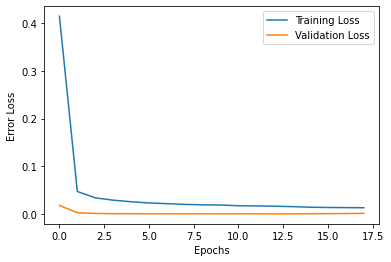

In [2]:
nodo_entreno = [50, 134, 187, 266]
entrenamiento = pd.DataFrame()
prediccion = pd.DataFrame()
variable = sensor
parte_entreno = 0.7

inicio = datetime.now()
#now = datetime.now()
#time_rnn = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

for en in nodo_entreno:
    datos_entreno = entreno.loc[entreno.loc[:,"codigoSerial"] == en]
    #datos_entreno = datos_entreno.iloc[:round(len(datos_entreno)*0.1),:]
    cant_entreno = round(len(datos_entreno)*parte_entreno)
    entrenamiento = pd.concat([entrenamiento,datos_entreno.iloc[:cant_entreno,:]],ignore_index=True)
    prediccion = pd.concat([prediccion,datos_entreno.iloc[cant_entreno:,:]],ignore_index=True)


entrenamiento["fechaHora"] = entrenamiento["fecha"] + " " + entrenamiento["hora"]
diferencias (entrenamiento,[variable],redondeo)

#df_small_noise = entrenamiento.loc[:,["fechaHora", variable+"_dif"]]
df_small_noise = entrenamiento.loc[:,["fechaHora", variable]]
#pd.to_datetime(df_small_noise["fechaHora"])
df_small_noise.set_index("fechaHora", inplace=True)

#df_daily_jumpsup = df_small_noise.copy() 


# Comentar si desea sacar los datos de predicción desde el set de entrenamiento. Si comenta esta línea, debe
#descomentar la línea que genera los datos sintéticos
#prediccion = datos.copy()
prediccion = prediccion[:38537] 

prediccion["fechaHora"] = pd.to_datetime(prediccion["fecha"] + " " + prediccion["hora"])
prediccion_ori, prediccion, outliers = synthetic_data(prediccion,0.1,20)
diferencias (prediccion,[variable],redondeo)

#df_daily_jumpsup = prediccion.loc[:,["fechaHora", variable+"_dif"]]
df_daily_jumpsup = prediccion.loc[:,["fechaHora", variable]]
#pd.to_datetime(df_daily_jumpsup["fechaHora"])
df_daily_jumpsup.set_index("fechaHora", inplace=True)



training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std

print("Number of training samples:", len(df_training_value))

TIME_STEPS = 1

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")

model.summary()
#plot_model(model, to_file='model_plot_convo.png', show_shapes=True, show_layer_names=True)

history = model.fit(
    x_train,
    x_train,
    verbose=0,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    validation_data=(x_train,x_train),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

fin = datetime.now()
#print("Tiempo RNN:", time_rnn.time())
#print("Tiempo de entrenamiento:",tiempo_entrenamiento)
print("Tiempo total:", fin-inicio)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Error Loss')
plt.legend()
#plt.savefig("Auto_training.eps", dpi=200, bbox_inches='tight')
plt.show()

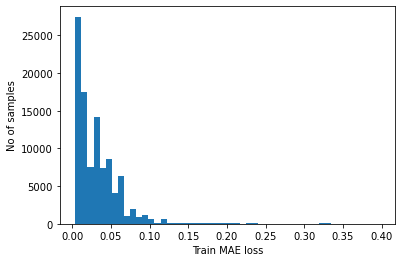

Reconstruction error threshold:  0.3974327207887871


In [3]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()


# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


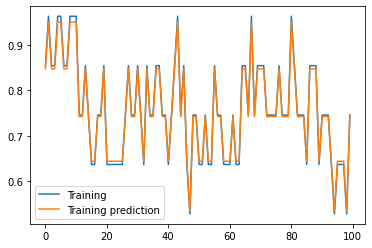

In [4]:
# Checking how the sequence is learnt

train = []
for i in range (len(x_train)):
    train.append(x_train[i][0][0])

train_pred = []
for i in range (len(x_train_pred)):
    train_pred.append(np.mean(x_train_pred[i]))

plt.plot(train[0:100], label="Training")
plt.plot(train_pred[0:100], label="Training prediction")
plt.legend()
#plt.savefig("Auto_prediction_training.eps", dpi=200, bbox_inches='tight')
plt.show()


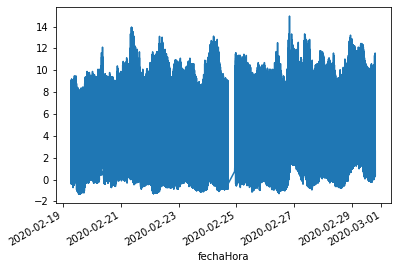

Test input shape:  (38537, 1, 1)


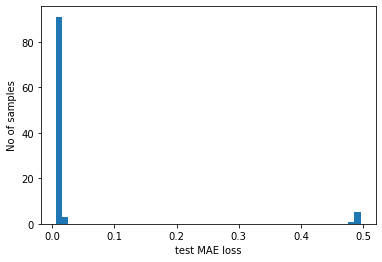

Number of anomaly samples:  3854
Indices of anomaly samples:  (array([   31,    37,    46, ..., 38514, 38520, 38533], dtype=int64),)


In [5]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss[0:100], bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [6]:
lista_pred = []
for i in range (len(x_test_pred)):
    lista_pred.append(np.mean(x_test_pred[i]))
# print(lista_pred[300:310])

# lista_test = []
# for i in range (len(x_test)):
#     lista_test.append(x_test[i][0][0])
# print(lista_test[0:50])

lista_pred[0:10]

index = np.where(anomalies)
prediccion['detected'] = prediccion.loc[list(index[0]),'pm25']


In [7]:
#prediccion.assign(detected=) = pd.DataFrame(columns =["outlier"])
#pred['outlier'] = [0]*len(prediccion)
prediccion['detected'] = prediccion.loc[list(index[0]),'pm25']





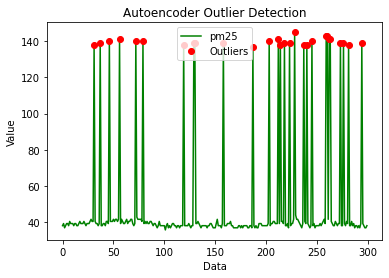

In [8]:
pred = prediccion[0:300]

#lista_pred = x_test_pred[2].reshape(100).tolist()# + x_test_pred[3].reshape(100).tolist()
#test_datos.append(x_test_pred[0].reshape(100).tolist())
#test_datos.append(x_test_pred[1].reshape(100).tolist())
#plt.plot(df_test_value.values[440:480], color='blue')
#plt.plot(prediccion.pm25.values[0:300], color='green', label="pm25")

plt.plot(pred.index, pred.pm25, color="green",label="pm25")
plt.plot(pred.index, pred.detected, 'o', color="red",label="Outliers")
plt.title('Autoencoder Outlier Detection')
plt.xlabel('Data')
plt.ylabel('Value')
#plt.plot(test_datos[0:1])
plt.legend(loc='upper center')
#plt.savefig("Auto_result.eps", dpi=200, bbox_inches='tight')
plt.show()

(1.0, 1.0, 1.0, 1.0)

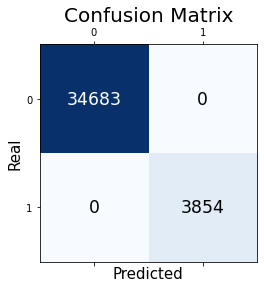

In [10]:
real = prediccion.pm25_outlier.tolist()
real = ['S' if value!='N' else value for value in real]
predicho = ['S' if value==True else value for value in anomalies]
predicho = ['N' if value==False else value for value in predicho]
confu_matrix (real[0:len(predicho)],predicho)

In [11]:
index = np.where(anomalies)
index[0]

outliers = ident_outliers[0:300][ident_outliers['LOF'] == 'S']
plt.plot(ident_outliers[0:300].index, ident_outliers[0:300].pm25, color="green",label="pm25")
plt.plot(outliers.index, outliers.pm25, 'o', color="red",label="Outliers")
plt.title('LOF Outlier Detection')
plt.legend(loc='upper center')
plt.xlabel('Data')
plt.ylabel('Value')
plt.savefig("LOF_result.eps", dpi=200, bbox_inches='tight') 
plt.show()

NameError: name 'ident_outliers' is not defined

### CORRECCIÓN DE OUTLIERS POR ESTRATEGIA DE TENDENCIA

            30        60       100       200       500
RMSE  3.211320  3.027336  2.939546  2.886879  2.852849
MAPE  5.688016  4.993313  4.643974  4.409589  4.246910
MAE   1.570878  1.394640  1.305972  1.248285  1.208458


TypeError: 'int' object is not iterable

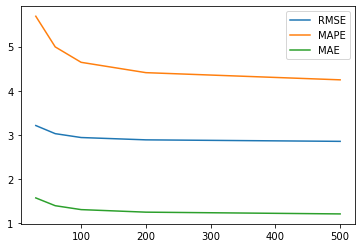

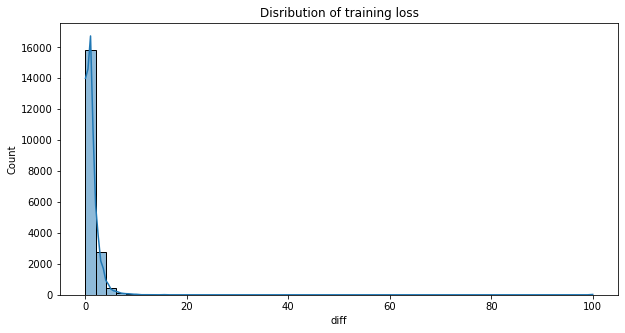

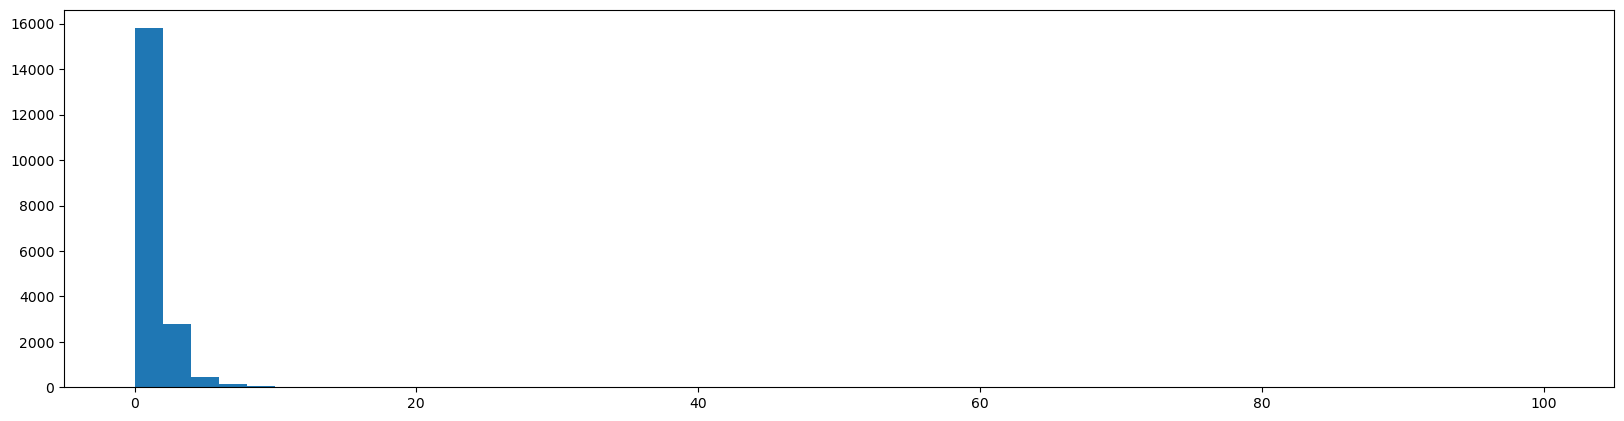

In [13]:

def corregir(variable,dif):
# Función que corrige el valor identificado como outlier. Lo que se hace es sacar el promedio de las últimas 
# diferecnias (valor de variable time_step) y sumarlo al valor anterior al outlier. Ese será el nuevo valor.
# Variable --> Lista de todos los datos, outliers y no outliers
# dif --> Lista de las diferencias de los últimos "time-step" valores
 
    if (variable[k] - variable [k-1]) >= 0:
        valor = variable[k-1] + abs(np.mean(dif))
    else:
        valor = variable[k-1] - abs(np.mean(dif))
    
    if valor < 0:
        valor = 0
    
    return round(valor,4)

# El dataframe con los datos marcados como outliers se llama "prediccion". En este DF se encuentra la columna "detected" 
# que tiene la marca "N" para los valores que no son outliers, y el valor del outlier para los que fueron identificados como outliers

time_step = [30, 60, 100, 200, 500] # Cantidad de datos de la memoria
nodos = prediccion.codigoSerial.unique().tolist()
datos_corregidos = pd.DataFrame()
errores = pd.DataFrame({'error':['RMSE','MAPE','MAE']})
c = 0
now = datetime.now()
time_tendencia = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

for ts in time_step:
    errores[ts] = 0

# 3.2 Ciclo de recorrido por cada nodo
    for n in nodos:
        inicio = datetime.now()
        c += 1
        #print("Nodo:", n, "es el", c, "de:", len(nodos), "**********************")
        corregidos = prediccion.loc[prediccion.loc[:,"codigoSerial"] == n]
        corregidos[sensor+"_corr_ten"] = corregidos[sensor] # Duplico la columna de los datos para los corregidos
        corregidos.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
        dif = []  # Lista para almacenar las diferencias de los valores

    # Correción de outliers 
        for k in range(2,len(corregidos)):
            
            dif.append(corregidos[sensor][k-1]-corregidos[sensor][k-2])
            del(dif[0:-ts])
            
            if (corregidos[sensor+"_outlier"][k] != "N"):
                ten_inicio = datetime.now()
                corregidos.loc[k,sensor+"_corr_ten"] = corregir(corregidos[sensor+"_corr_ten"],dif)
                ten_fin = datetime.now()
                time_tendencia = time_tendencia +(ten_fin-ten_inicio)

    # 3.4 Almacenamiento de los datos corregidos en un dataframe    
        datos_corregidos = pd.concat([datos_corregidos,corregidos],ignore_index=True)

        fin = datetime.now()
        #print("Tiempo Tendencia:", time_tendencia.time())
        #print("Tiempo total:", fin-inicio)

    #    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(20,6), dpi=100)
        
    #    ax1.set_title("Corrección por TENDENCIA del nodo "+str(n))
    #    ax1.plot(datos_corregidos[sensor].tolist(), label="Antes")
    #    ax1.plot(datos_corregidos[sensor+"_corr_ten"].tolist(), label="Después")
    #    ax1.legend()

    # 3.5 Cálculo de errores
    valores = datos_corregidos[['pm25_outlier','pm25_corr_ten']].loc[datos_corregidos.loc[:, 'pm25_outlier'] != 'N']
    RMSE = sqrt (mean_squared_error (valores['pm25_outlier'], valores['pm25_corr_ten']))

    def mape ( actual , pred ):
        actual, pred = np.array (actual), np.array (pred)
        return np.mean (np.abs ((actual - pred) / actual)) * 100
    MAPE = mape(valores['pm25_outlier'], valores['pm25_corr_ten'])

    MAE = mean_absolute_error(valores['pm25_outlier'], valores['pm25_corr_ten'])

    errores[ts] = [RMSE, MAPE, MAE]


errores.set_index('error',inplace=True)
errores.index.name = None
print(errores)
errores = errores.T
lines = errores.plot.line()

valores['diff'] =  abs(valores['pm25_outlier'] - valores['pm25_corr_ten'])
plt.figure(figsize = (10,5))
sns.histplot(valores['diff'], bins=50, kde=True);
plt.title('Disribution of training loss')

bins = 50
plt.figure(figsize=(20, 5), dpi=100)
#sns.histplot(entrenamiento[sensor+'_dif'], bins=ks, kde=True, stat='count');
    
density, rangos, _= plt.hist(valores['diff'],density=False, bins=50)
count, _= np.histogram(valores['diff'],bins)
for x,y, num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y, num, fontsize=10)
                
plt.title('HBOS Histogram')
plt.xlabel('bins')
plt.ylabel('Frecuency')
plt.xticks(bins)
#plt.savefig("HBOS_histogram.svg", dpi=200, bbox_inches='tight')    
plt.show() #dibujamos el histograma


In [14]:
max(valores['diff'])

100.0

### CALCULAR EL ERROR CUADRÁTICO MEDIO (RMSE)

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics  import mean_absolute_error
from math import sqrt


valores = datos_corregidos[['pm25_outlier','pm25_corr_ten']].loc[datos_corregidos.loc[:, 'pm25_outlier'] != 'N']

# Calcular RMSE (Error cuadrático medio)
# Cuanto mayor sea el RMSE, mayor será la diferencia entre los valores predichos y observados, lo que significa que peor se ajusta un modelo a los datos.
RMSE = sqrt (mean_squared_error (valores['pm25_outlier'], valores['pm25_corr_ten']))
print('RMSE: ',RMSE)



# Calcular MAPE (Error porcentual absoluto medio)
# Un valor MAPE del 11,5% significa que la diferencia media entre el valor predicho y el valor real es del 11,5%.
# Cuanto menor sea el valor de MAPE, mejor podrá predecir los valores un modelo.
def mape ( actual , pred ):
    actual, pred = np.array (actual), np.array (pred)
    return np.mean (np.abs ((actual - pred) / actual)) * 100

MAPE = mape(valores['pm25_outlier'], valores['pm25_corr_ten'])
print('MAPE: ', MAPE)



# Calcular MAE (Error absoluto medio)
# Esto nos dice que cual es la diferencia promedio entre el valor real de los datos y el valor predicho por el modelo
MAE = mean_absolute_error(valores['pm25_outlier'], valores['pm25_corr_ten'])
print('MAE: ', MAE)


RMSE:  2.2820366975795188
MAPE:  3.902908471597858
MAE:  1.1180392579138556
